In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import json
import os
import shutil
import random
from PIL import Image

In [4]:
# Définir les transformations pour les données
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224
    transforms.ToTensor(),  # Convertir les images en tenseurs PyTorch
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliser les images (FashionMNIST est en niveaux de gris)
])

# Télécharger et charger le jeu de données FashionMNIST
dataset = datasets.FashionMNIST(root='./data', 
                                train=True, 
                                transform=transform, 
                                download=True)

# Séparer les données en ensemble d'entraînement et de test
# Calculer la taille de chaque sous-dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Diviser le dataset en ensemble d'entraînement et de test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Créer des DataLoader pour les ensembles d'entraînement et de test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Afficher les tailles des datasets pour vérification
print(f'Taille du dataset d\'entraînement: {len(train_dataset)}')
print(f'Taille du dataset de test: {len(test_dataset)}')

Taille du dataset d'entraînement: 48000
Taille du dataset de test: 12000


In [5]:
# Création du module personnalisé pour la régression logistique
class RegressionLogistique(torch.nn.Module):
    
    # Définition du constructeur
    def __init__(self, n_entrees, n_sorties):
        super().__init__()
        self.lineaire = torch.nn.Linear(n_entrees, n_sorties)
        
    # Prédiction
    def forward(self, x):
        # y_pred = torch.sigmoid(self.lineaire(x))
        y_pred = torch.softmax(self.lineaire(x), dim=1)  # Utiliser softmax pour la régression logistique multinomiale
        return y_pred
    

# Définir le modèle
n_entrees = 224 * 224
n_sorties = 10
reg_log = RegressionLogistique(n_entrees, n_sorties)

# Définition de l'optimiseur
optimiseur = torch.optim.SGD(reg_log.parameters(), lr=0.001)

# Définition de la perte d'entropie croisée
critere = torch.nn.CrossEntropyLoss()

epochs = 25
Perte = []
acc = []

for epoque in range(epochs):
    reg_log.train()
    for images, etiquettes in train_loader:
        optimiseur.zero_grad()
        images = images.view(-1, n_entrees)  # Aplatir les images
        sorties = reg_log(images)
        perte = critere(sorties, etiquettes)
        perte.backward()
        optimiseur.step()
    
    Perte.append(perte.item())
    
    correct = 0
    reg_log.eval()
    with torch.no_grad():
        for images, etiquettes in test_loader:
            images = images.view(-1, n_entrees)  # Aplatir les images
            sorties = reg_log(images)
            _, predit = torch.max(sorties.data, 1)
            correct += (predit == etiquettes).sum().item()
    
    precision = 100 * correct / len(test_dataset)
    acc.append(precision)
    
    if epoque % 5 == 0:
        print('Époque : {}. Perte : {}. Précision : {}'.format(epoque, perte.item(), precision))

Époque : 0. Perte : 1.6601829528808594. Précision : 77.725
Époque : 5. Perte : 1.7049317359924316. Précision : 80.26666666666667
Époque : 10. Perte : 1.6431747674942017. Précision : 81.36666666666666


KeyboardInterrupt: 

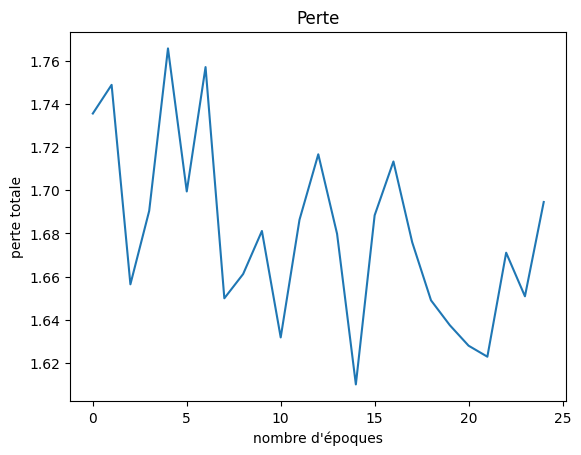

In [ ]:
plt.plot(Perte)
plt.xlabel("nombre d'époques")
plt.ylabel("perte totale")
plt.title("Perte")
plt.show()

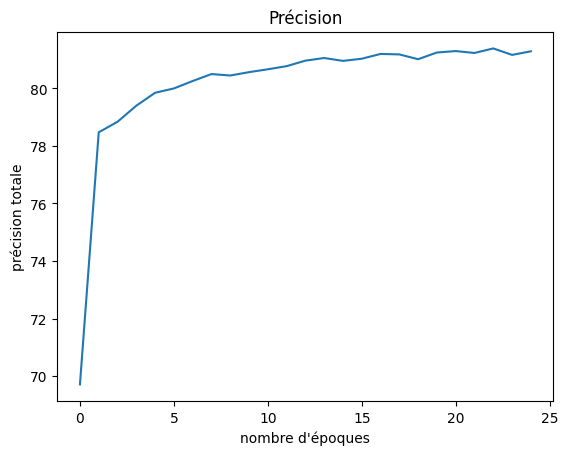

In [ ]:
plt.plot(acc)
plt.xlabel("nombre d'époques")
plt.ylabel("précision totale")
plt.title("Précision")
plt.show()

In [6]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([64, 1, 224, 224]) type: torch.FloatTensor
target: torch.Size([64]) type: torch.LongTensor


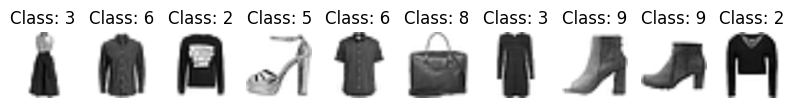

In [8]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(224,224), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))